In [258]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import pickle
from torch.utils.data import Dataset
import random

In [259]:
seed = 100
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [260]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [261]:
device = torch.device('cuda')
device

device(type='cuda')

In [262]:
with open('train.pkl', 'rb') as f:
    pck_data = pickle.load(f)

random.Random(seed).shuffle(pck_data)
pck_data[0]

(array([ 68., 153.,  41.,  93., 100.,   5., 158., 158.,   3.,  21., 153.,
        153.,   2.,  68.,  43.,  12., 180.,   0.,  47.,  78., 114., 114.,
         82., 168., 153., 153.,  41.,  93., 100.,   5., 158., 158.,   3.,
         21., 153., 153.,   2.,  68.,  43.,  12., 180.,   0.,  47.,  78.,
        114., 114.,   0.,   0.,  88.,  88.,   9., 156., 109.,  78.,  30.,
        151.,  92., 109., 172.,   5.,  19., 185.,  30.,  78.,  36.,  60.,
        185., 157., 144., 144., 114., 180.,  60., 153.,  41.,  93., 100.,
          5., 158., 158.,   3.,  21., 153., 153., 126., 136.,  68.,  92.,
         76.,  36.,  92., 100.,   5.,  92., 158.,  21.,  80., 168., 100.,
        153.,   2.,  80.,  80.,  80.,  80.,  80.,  80.,  -1.]), 3)

{3: 441, 1: 478, 0: 1630, 4: 236, 2: 154}


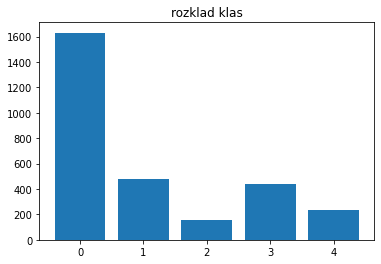

In [263]:
counts = {}
for record in pck_data:
    if record[1] in counts:
        counts[record[1]] += 1
    else:
        counts[record[1]] = 1
print(counts)

plt.bar(list(counts.keys()), list(counts.values()))
plt.title("rozklad klas")
plt.show()

In [264]:
data = []
targets = []
max_val = float("-inf")
min_val = float("inf")
for record in pck_data:
    data.append(torch.from_numpy(np.array(record[0])))
    targets.append(torch.from_numpy(np.array(record[1])))
    max_val = data[-1].max() if data[-1].max() > max_val else max_val
    min_val = data[-1].min() if data[-1].min() < min_val else min_val

max_val, min_val

(tensor(191., dtype=torch.float64), tensor(-1., dtype=torch.float64))

In [265]:
class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [266]:
train_indices = int(len(data) * 0.75)
data = [( (x - min_val) / (max_val-min_val) - 0.5).float() for x in data]
train_set = VariableLenDataset(data[:train_indices], targets[:train_indices])
test_set = VariableLenDataset(data[train_indices:], targets[train_indices:])

In [267]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = -1

def pad_collate(batch, pad_value=-1):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    return xx_pad, torch.Tensor(yy), torch.Tensor(x_lens)

In [268]:
batch_size = 40
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=pad_collate, num_workers=4, pin_memory=True)
torch.set_printoptions(profile="default")
for a,b,c in test_loader:
    print(a[30])
    break

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([ 0.0260, -0.0938, -0.1615,  ..., -1.0000, -1.0000, -1.0000])


In [269]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, batch_size,bidirectional = False):
        super().__init__()
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, dropout=0.2)
        self.fc1 = nn.Linear( (3*hidden_size*self.bidirectional), (3*hidden_size*self.bidirectional) // 2 )
        self.bn1 = nn.BatchNorm1d((3*hidden_size*self.bidirectional) // 2)
        self.act1 = nn.ReLU()
        self.d1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear((3*hidden_size*self.bidirectional), out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden, lens_x):
        curr_b = x.shape[0]
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        out = torch.zeros((curr_b, 3*self.bidirectional*self.hidden_size), requires_grad=True).to(device)
        for i in range(curr_b):
          idx1 = lens_x[i]-3
          idx2 = lens_x[i]
          out[i, :] = all_outputs[i, idx1:idx2, :].flatten()
        # x = self.fc1(out)
        # x = self.bn1(x)
        # x = self.act1(x)
        # x = self.d1(x)
        x = self.fc2(out)
        return x, hidden

In [270]:

#torch.set_printoptions(profile="full")


model = LSTMClassifier(1, 32, 2, 5, batch_size, False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fun = nn.CrossEntropyLoss(weight=torch.Tensor([1, 2, 3, 2, 3]).to(device), reduction='mean')

In [271]:
import sys
model.train()

losses_train = []
losses_epoch_train = []
losses_test = []
losses_epoch_test = []

acc_train = []
acc_epoch_train = []
acc_test = []
acc_epoch_test = []


for epoch in range(250):
    model.train()
    for x, targets, lens in train_loader:
        targets = targets.long()
        x = x.to(device).unsqueeze(2)
        lens = lens.long().to(device)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, (hidden,state), lens)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses_epoch_train.append(loss.item())
        acc = (preds.argmax(dim=1) == targets).sum() / preds.shape[0]
        acc_epoch_train.append(acc.cpu())
    losses_train.append(np.mean(losses_epoch_train))
    acc_train.append(np.mean(acc_epoch_train))

    model.eval()
    with torch.no_grad():
        for x, targets, lens in test_loader:
            targets = targets.long()
            x = x.to(device).unsqueeze(2)
            lens = lens.long().to(device)
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = model(x, (hidden,state), lens)
            losses_epoch_test.append(loss.item())
            acc = (preds.argmax(dim=1) == targets).sum() / preds.shape[0]
            acc_epoch_test.append(acc.cpu())
    losses_test.append(np.mean(losses_epoch_test))
    acc_test.append(np.mean(acc_epoch_test))
    print(f"Epoch: {epoch}, loss train: {losses_train[-1]:.3}, loss test: {losses_test[-1]:.3}")
    print(f"Epoch: {epoch}, acc train: {acc_train[-1]:.3}, acc test: {acc_test[-1]:.3}")

Epoch: 0, loss train: 1.54, loss test: 1.51
Epoch: 0, acc train: 0.547, acc test: 0.556
Epoch: 1, loss train: 1.53, loss test: 1.31
Epoch: 1, acc train: 0.554, acc test: 0.556
Epoch: 2, loss train: 1.53, loss test: 1.29
Epoch: 2, acc train: 0.555, acc test: 0.556
Epoch: 3, loss train: 1.53, loss test: 1.44
Epoch: 3, acc train: 0.553, acc test: 0.559
Epoch: 4, loss train: 1.52, loss test: 1.39
Epoch: 4, acc train: 0.554, acc test: 0.56
Epoch: 5, loss train: 1.51, loss test: 1.39
Epoch: 5, acc train: 0.553, acc test: 0.566
Epoch: 6, loss train: 1.52, loss test: 1.42
Epoch: 6, acc train: 0.552, acc test: 0.565
Epoch: 7, loss train: 1.52, loss test: 1.38
Epoch: 7, acc train: 0.552, acc test: 0.564
Epoch: 8, loss train: 1.52, loss test: 1.34
Epoch: 8, acc train: 0.553, acc test: 0.563
Epoch: 9, loss train: 1.52, loss test: 1.35
Epoch: 9, acc train: 0.553, acc test: 0.562
Epoch: 10, loss train: 1.52, loss test: 1.32
Epoch: 10, acc train: 0.553, acc test: 0.562
Epoch: 11, loss train: 1.52, lo

KeyboardInterrupt: ignored

In [ ]:
plt.figure()
plt.grid(True)
plt.plot(losses_train)
plt.plot(losses_test)
plt.title("Loss")
plt.legend(["train", "valid"])

plt.figure()
plt.grid(True)
plt.title("Accuracy")
plt.plot(acc_train)
plt.plot(acc_test)
plt.legend(["train", "valid"])
print('Finished Training')

In [ ]:
correct_preds = [0 for _ in range(5)]
total_preds = [0 for _ in range(5)]


model.eval()
with torch.no_grad():
    for x, targets, lens in test_loader:
        targets = targets.long()
        x = x.to(device).unsqueeze(2)
        lens = lens.long().to(device)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, (hidden,state), lens)
        losses_epoch_test.append(loss.item())
        acc = (preds.argmax(dim=1) == targets).sum() / preds.shape[0]
        acc_epoch_test.append(acc.cpu())


        _, max_preds = torch.max(preds, 1)
        for label, prediction in zip(targets, max_preds):
          label = label.item()
          if label == prediction:
              correct_preds[label] += 1
          total_preds[label] += 1


print(f"Acc: {np.mean(acc_epoch_test)}")

class_accs = []
for i, correct_count in enumerate(correct_preds):
    accuracy = 100 * float(correct_count) / total_preds[i]
    print(f"Accuracy for class {i} is: {accuracy} %")
    class_accs.append(accuracy)

print(f"Avg class acc: {np.array(class_accs).mean()}")

In [ ]:
# torch.save(model.state_dict(), 'model42')

In [ ]:
# Predykcje dla zbioru testowego
predictions = []
composers = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
with open('test_no_target.pkl', 'rb') as f:
    pck_data_test = pickle.load(f)
print(len(pck_data_test))
data_test = []
targets = []
for record in pck_data_test:
    data_test.append(torch.from_numpy(np.array(record)))
    targets.append(torch.Tensor([-10]))

data_test = [( (x - min_val) / (max_val-min_val) - 0.5).float() for x in data_test]
test_set = VariableLenDataset(data_test, targets)
test_loader = DataLoader(test_set, batch_size=batch_size, collate_fn=pad_collate)

for a,b,c in test_loader:
  print(a[0])
  break
predictions = []
model.eval()
with torch.no_grad():
    for x, targets, lens in test_loader:
        x = x.to(device).unsqueeze(2)
        lens = lens.long().to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, (hidden,state), lens)
        preds = preds.argmax(dim=1)
        predictions.append(preds.cpu().detach().numpy())

predictions = np.concatenate(predictions, axis=0)


In [ ]:
df = pd.DataFrame(predictions)

In [ ]:
df.to_csv("predictions.csv", index=False, header=False)